In [ ]:
! python -m pip -q install federpy towhee hnswlib numpy

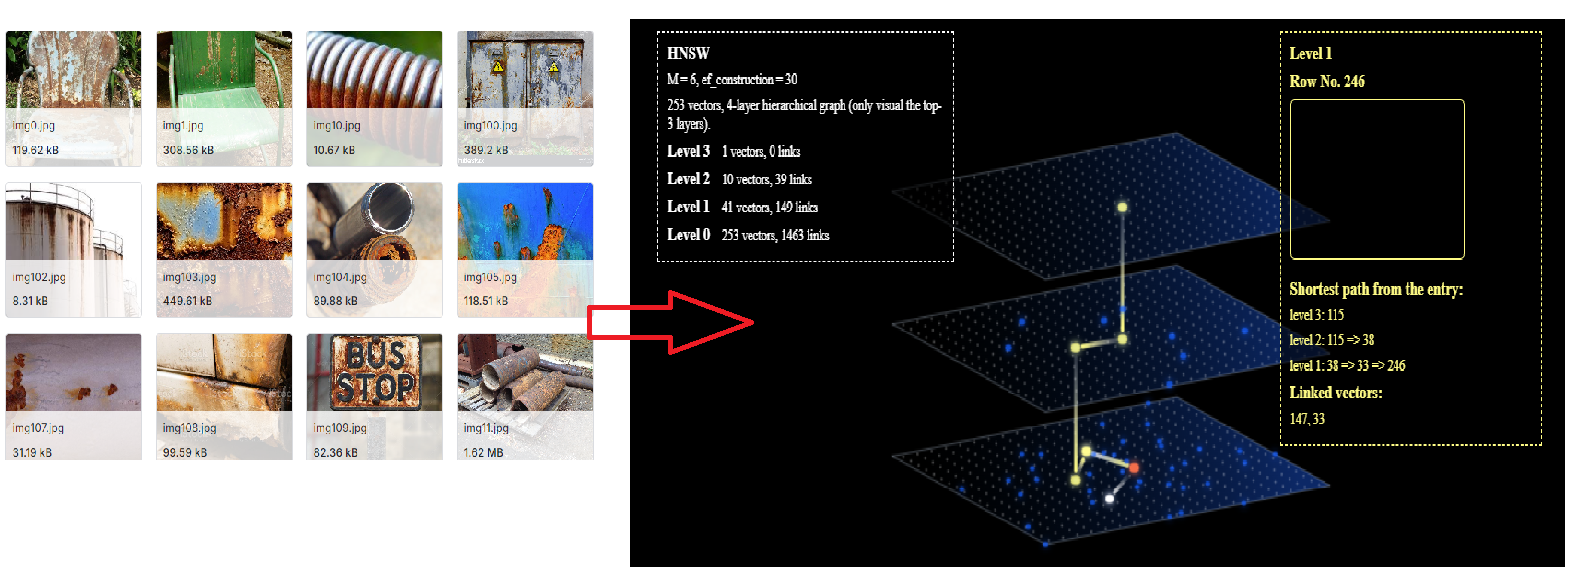

In [28]:
from IPython.display import Image
Image(filename='corrosion_vectors.png')

In [ ]:
! unzip -q -o archive.zip

In [6]:
import glob

images = glob.glob('JPEGImages/*.jpg')
print(len(images))

253


In [9]:
from towhee import pipe, ops
import numpy as np

p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', lambda x: glob.glob(x))
        .map('img_path', 'img', ops.image_decode.cv2())
        .map('img', 'vec', ops.image_embedding.timm(model_name='resnet50'))
        .output('vec')
)
vectors = p_embed('JPEGImages/*.jpg').to_list()
vectors = np.array(np.squeeze(vectors), dtype="float32")
print(vectors.shape)

(253, 2048)


In [10]:
import hnswlib

def save_hnsw_index(vec, file_name):
    dim = vec.shape[1]
    max_elements = vec.shape[0]
    hnsw_index = hnswlib.Index(space='l2', dim=dim)
    hnsw_index.init_index(max_elements=max_elements, ef_construction=30, M=6)
    hnsw_index.add_items(vec)

    hnsw_index.save_index(file_name)
save_hnsw_index(vectors, 'hnswlib.index')

In [14]:
# import
from federpy.federpy import FederPy

In [15]:

# Lite version, Only input indexFile, No viewParams, No images.
# index file built by hnswlib or faiss.
hnswSource = 'hnswlib'
hnswIndexFile = 'hnswlib.index'

federPy_hnsw_lite = FederPy(hnswIndexFile, hnswSource)

# federPy_hnsw_lite.overview()
federPy_hnsw_lite.searchRandTestVec()

In [ ]:
# init federpy
hnswViewParams = {
    "width": 800,
    "height": 400,
    "mediaUrls": ['this is the text content of No.%s' % i for i in range(len(images))],
    "mediaType": "image"

}
federPy_hnsw = FederPy(hnswIndexFile, hnswSource, **hnswViewParams)
federPy_hnsw.overview()

In [ ]:
from IPython.display import HTML


html = federPy_hnsw.getHtml()
print(html)
#copy this html content onto a file! currently this is manual step

In [20]:
federPy_hnsw.setSearchParams({"k": 6, "ef": 8}).searchRandTestVec()

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8000)"))

In [ ]:
!python -m http.server 8000

In [25]:
from IPython.display import Javascript

def show_port(port, height=400):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%s)
    fm.width = '95%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, height) ))

In [27]:
get_ipython().system_raw('python3 -m http.server 8888 &')
show_port(8888)
# this will display all your files in a local browser from there you need to open the html file you saved with proper links! To see the viz below!

<IPython.core.display.Javascript object>